# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.image as mpimg
from IPython.display import display
import scikitplot as skplt

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [2]:
# some general parameters for plots
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams['axes.edgecolor'] = "grey"
mpl.rcParams['figure.edgecolor'] = "grey"
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['legend.edgecolor'] = "grey"
mpl.rcParams['legend.shadow'] = False
mpl.rcParams["legend.framealpha"] = 1
mpl.rcParams['font.weight'] = "bold"
mpl.rcParams['axes.labelweight'] = "bold"
mpl.rcParams['axes.titleweight'] = "bold"

In [3]:
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report

In [36]:
def evaluation (model,X, y, thresh = 30):
    # for model produce confusion matrix, classification report andmodified ratio
    y_pred=model.predict(X)
    skplt.metrics.plot_confusion_matrix(y, y_pred, figsize=(10,10), text_fontsize=20)
    print(classification_report(y,y_pred))

In [5]:
def feature_importances (model, preprocessor, X, y, debug = False, custom_feature_state = False, custom_feature_list=None):
    # plot feature importances with predefined model and preprocessor, get feature names either from input dataframe
    # if all are used or define a custom one if subset is used
    if custom_feature_state:
        feature_names = custom_feature_list
    else:
        cat_features = list(X.columns[X.dtypes ==  "category"])
        numeric_features = list(X.columns[X.dtypes ==  "float"])
        cat = None
        if "base_1" in X.columns:
            bases = ["_A","_C","_T","_G"]
            cat = [elm + base for elm in cat_features for base in bases ]
        feature_names = numeric_features + cat

    X_trans = preprocessor.fit_transform(X)

    if debug:
        print(feature_names)
        print(len(feature_names))
    model.fit(X_trans, y)

    skplt.estimators.plot_feature_importances(model, feature_names=feature_names, max_num_features=10)
    plt.xticks(rotation=90);

# Load Data

In [6]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category",
                                  "modified_status_rolling_max":"object"})
df_combined = df_combined.astype({"ref_number":"object"})

# Exploratory Data Analysis

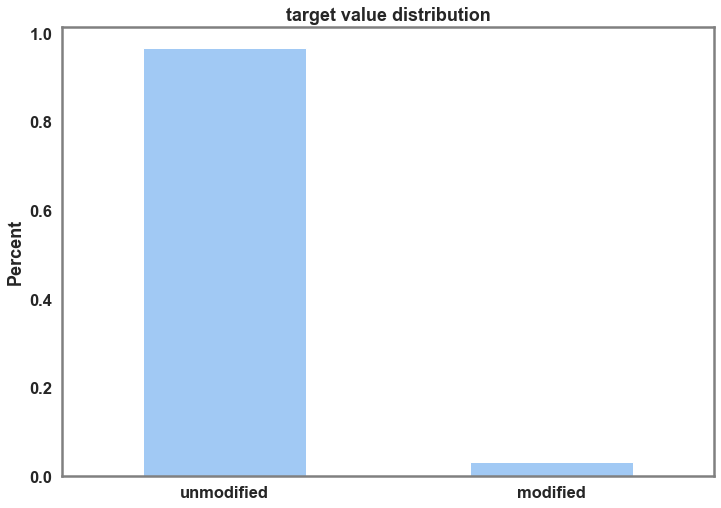

In [7]:
ax = df_combined.modified_status.value_counts(normalize=True).plot.bar()
ax.set(ylabel = "Percent", xticklabels=["unmodified", "modified"])
plt.xticks(rotation="horizontal")
plt.title("target value distribution");

## Interactive Plot

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [9]:
df_dnaviewer = df_combined[["ref_number","file_name","base_3","dwell_time_median","dwell_time_rolling_min",
                            "dwell_time_diff_to_median","modified_status"]]

In [10]:
def getIndexes(dfObj, value):
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    if seriesObj.any():
        columnNames = list(seriesObj[seriesObj == True].index)
        # Iterate over list of columns and fetch the rows indexes where value exists
        for col in columnNames:
            rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row))
        # Return a list of tuples indicating the positions of value in the dataframe
    else:
        listOfPos = False
    return listOfPos

In [11]:
def plot_dna(i, col, axs, ref, startpos, stoppos, df_temp):
    start,stop = 0,15
    font =  {'size': 24, 
             'weight':'bold'}
    
    
    sequence = "".join(df_temp.base_3.values)
    
    modified_positions = getIndexes(df_temp[["base_3","modified_status"]], 1.0)
    
    if modified_positions:
            for elm in modified_positions:

                axs[0,col].axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=0)
                axs[1,col].axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=1)
                axs[2,col].axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=1)
                axs[3,col].axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=1)


            
    box1 = patches.Rectangle (xy=(4.5,1), width = 5, height = 2, edgecolor="grey",
                             linewidth=2.5, facecolor = "#FFB482")
    box2 = patches.FancyBboxPatch (xy=(6.5,5), width = 1, height = 2, edgecolor="grey",
                             linewidth=2.5, facecolor = "#A1C9F4", boxstyle = "Round4")
    
    axs[0,col].add_patch(box1)
    axs[0,col].add_patch(box2)
    axs[0,col].set_ylim(0,10)
    axs[0,col].text(7,2,s="reading frame", ha="center", va="center")
    axs[0,col].text(7,6,s="center", ha="center", va="center")
    axs[0,col].text(-0.3,2, va="center", ha="center", s="3'")
    axs[0,col].text(14.3,2, va="center", ha="center", s="5'")
    axs[0,col].plot(np.arange(start,stop),np.full(stop,2), color="grey", zorder=0)
    axs[0,col].plot([4.5,6.5],[3,5],color = "grey", zorder=0)
    axs[0,col].plot([7.5,9.5],[5,3], color="grey", zorder=0)
    axs[0,col].axis("off")
    axs[0,col].set_yticklabels([""])
    
    bl = "#A1C9F4"
    gr = "#8DE5A1"
    og = "#FFB482"
    
    bar_colors = [gr,gr,gr,gr,gr,og,og,bl,og,og,gr,gr,gr,gr,gr,]
    
    axs[1,col].bar(x=range(0,stop-start),height=df_temp.dwell_time_median, linewidth=2.5,
            edgecolor="grey",zorder=2, color = bar_colors)
    axs[1,col].set_ylabel("Dwell Time\nMedian")
    axs[1,col].set_ylim(0,0.1)
    axs[1,col].set_yticklabels([""])
    
    
    axs[2,col].bar(x=range(0,stop-start),height=df_temp.dwell_time_rolling_min, linewidth=2.5,
            edgecolor="grey",zorder=2, color = bar_colors)
    axs[2,col].set_ylabel("Dwell Time\nRolling Minimum")
    axs[2,col].set_ylim(0,0.03)
    axs[2,col].set_yticklabels([""])
    
    axs[3,col].bar(x=range(0,stop-start),height=df_temp.dwell_time_diff_to_median, linewidth=2.5, 
            edgecolor="grey",zorder=2, color = bar_colors)
    axs[3,col].set_ylabel("Dwell Time\nDiff to Median")
    axs[3,col].set_ylim(0,0.1)
    axs[3,col].set_yticklabels([""])
    axs[3,col].set_xticks(np.arange(start,stop))
    axs[3,col].set_xticklabels(list(sequence), fontdict=font )
    axs[3,col].set_xlim(-0.5,14.5)
    
    if df_temp.base_3.iloc[7] == "A":
        img=mpimg.imread('base_img/adenosin.png')
    elif df_temp.base_3.iloc[7] == "C":
        img=mpimg.imread('base_img/cytidin.png')
    elif df_temp.base_3.iloc[7] == "G":
        img=mpimg.imread('base_img/guanosin.png')
    elif df_temp.base_3.iloc[7] == "T":
        img=mpimg.imread('base_img/uridin.png')
    axs[1,2].imshow(img)
    axs[1,2].set_xlim(-100,1200)
    axs[1,2].set_ylim(1100,-100)
    axs[1,2].set_yticklabels([""])
    axs[1,2].set_xticklabels([""])
    axs[1,2].axis("off")
    
    if modified_positions:
            for elm in modified_positions:
                if elm == 7:
                    img2=mpimg.imread('base_img/1m7.png')
                    axs[2,2].imshow(img2)
    axs[2,2].set_xlim(-100,1400)
    axs[2,2].set_ylim(1100,-100)
    axs[2,2].set_yticklabels([""])
    axs[2,2].set_xticklabels([""])
    axs[2,2].axis("off")

In [12]:
play = widgets.Play(
    value=0,
    min=0,
    max=181,
    step=1,
    interval=2500,
    description="Press play",
    disabled=False)
slider = widgets.IntSlider(continuous_update=False)
text = widgets.IntText()
toggle = widgets.ToggleButtons(options=["0","1","2","3","4"])

#display(text)

widgets.jslink((slider, 'value'), (text, 'value'))
widgets.jslink((play, 'value'), (slider, 'value'))
playbox = widgets.HBox([play, text])
display(playbox)

@interact(i = play,
          ref=toggle)

def sequencing_show(i,ref):
    
    start_i = i
    stop_i =i+15
    
    df_temp_mod = df_dnaviewer[(df_dnaviewer["file_name"]=="modified_rep_1.tsv") &
                (df_dnaviewer["ref_number"]=="ref_000"+ref)][start_i:stop_i].reset_index()
    df_temp_unmod = df_dnaviewer[(df_dnaviewer["file_name"]=="unmodified_rep_1.tsv") &
                (df_dnaviewer["ref_number"]=="ref_000"+ref)][start_i:stop_i].reset_index()
    
    fig, axs = plt.subplots(
        4, 3,   figsize=(20, 10), 
        sharex='col', 
        gridspec_kw={"width_ratios": [2,2,1]}
    )
    
   
    plot_dna(i,0,axs,ref, start_i, stop_i, df_temp_mod)
    plot_dna(i,1,axs,ref, start_i, stop_i, df_temp_unmod)
    
    
    #plt.figure(edgecolor = "grey")
    plt.suptitle("DNA-Nanoporesequencing readout",weight="bold")
    #plt.tight_layout()
    plt.subplots_adjust(top=0.95,hspace = 0)
    axs[1,1].set_ylabel("")
    axs[2,1].set_ylabel("")
    axs[3,1].set_ylabel("")
    
    axs[0,2].set_visible(False)
    axs[3,2].bar(x = (400,900), height= (df_temp_mod.dwell_time_median.iloc[7],
                                         df_temp_unmod.dwell_time_median.iloc[7]), width=400)
    #axs[3,2].set_xlim(-0.5,1.5)
    axs[3,2].set_xticks([400,900])
    axs[3,2].set_xticklabels(["Mod","Unmod"] )
    axs[3,2].set_ylim(0,0.1)
    axs[3,2].set_yticklabels([""])
    axs[3,2].set_ylabel("Dwell Time\nMedian")
    



interactive(children=(Play(value=0, description='Press play', interval=2500, max=181), ToggleButtons(descripti…

# Model Selection

## Model Selector Class

In [13]:
class ModelSelector():

    def __init__(self, preprocessor,cv_state =True, sampler=None, instance_name=None):
        # initialise class with predetrmined models and tests, maybe add functions to add/change them afterwards?
        # add option to use a sampler (default = none)
        self.results = []
        self.name = []
        self.preprocessor = preprocessor
        self.sampler = sampler
        self.cv = []
        self.labels = []
        self.cv_state = cv_state
        self.scoring = {'precision':'precision',
                        'recall': 'recall',
                        'f1score':'f1',
                        'roc auc':'roc_auc'}
        self.models = [
                        ('LR', LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1)),
                        ('KNN', KNeighborsClassifier(n_jobs = -1)),
                        ('RF', RandomForestClassifier(random_state=seed, n_jobs = -1)),
                        ('ADAB', AdaBoostClassifier(random_state=seed)),
                        ('XGB',  XGBClassifier(random_state=seed, n_jobs = -1)),
                        ('SVC', SVC(random_state=seed)),
                        ('GNB', GaussianNB()),
                        ('MLP', MLPClassifier(random_state=seed))
                    ]
        self.instance_name = instance_name
        self.tests = ["test_"+elm for elm in self.scoring.keys()]
        self.best_results= []


    # function for determining the cvs, if True do cv for each ref_num
    def __cv__(self, X):
        if self.cv_state == True:
            self.labels = X.ref_number.values
            self.cv = [(np.where(self.labels != label)[0], np.where(self.labels == label)[0]) for label in np.unique(self.labels)]
        else:
            self.cv = 5


    # fit each model and do cv and record cvs and names
    def select_model(self, X, y, state):
        self.cv_state = state
        self.__cv__(X)
        for name, model in self.models:
            model_pipe = Pipeline([(self.preprocessor.__class__.__name__,self.preprocessor),
                                   (self.sampler.__class__.__name__,self.sampler),("name",model)])
            cv_results = cross_validate(model_pipe, X, y, cv=self.cv, scoring=self.scoring, n_jobs=-1, return_train_score=True)
            self.results.append(cv_results)
            self.name.append(name)

    def plot_selection(self):
        # plot the test scores for each test and each model
        plt.figure(figsize = (15,8))
        plt.suptitle('Algorithm Comparison for ' + self.instance_name)
        for idx, test in enumerate(self.tests):
            temp_results = [self.results[i][test] for i in range(len(self.results))]
            plt.subplot(1,len(self.tests),idx+1)
            sns.boxplot(y = temp_results, x = self.name)
            plt.title(test)
            plt.xticks(rotation = 90)
            plt.ylim(0,1.05)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)

    def get_scores(self, top = 3):
        # get test scores for top 3 tests for each measure and return them as a dataframe
        for idx, test in enumerate(self.tests):
            temp_results = [np.mean(self.results[i][test]) for i in range(len(self.results))]
            test_name = [test for i in range(len(self.name))]
            instance_name = [self.instance_name for i in range (len(self.name))]
            temp_best = sorted(zip(temp_results,self.name,test_name, instance_name), reverse = True)[:top]
            self.best_results.append(temp_best)

        test= pd.DataFrame()
        for i in range(np.array(self.best_results).shape[0]):
            test= pd.concat([test, pd.DataFrame(np.array(self.best_results)[i])], axis=0)
        test.columns = ["test_result","model","test", "instance_name"]
        test.test_result = test.test_result.astype(float)
        test.set_index(["instance_name","test","model"], inplace = True)
        return(test)


## Manual Train Test Split

In [14]:
# manual train test split according to ref_num to preserve sequence sequence identity

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
#train_ref = ["ref_0000","ref_0001","ref_0002"]
#test_ref = ["ref_0003"]

In [15]:
seed = 7

In [16]:
X_finaltest_combined = df_combined[df_combined["ref_number"].isin(final_ref)]
y_finaltest_combined = X_finaltest_combined.pop("modified_status")
X_val_combined = df_combined[df_combined["ref_number"].isin(val_ref)]
y_val_combined = X_val_combined.pop("modified_status")

In [17]:
# cv by hand produces 4 fits singling each of the four remaining dna strands out each time, to provide
# realistic cross validation
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

## Setup Pipeline

In [18]:
numeric_features_combined = list(X_finaltest_combined .columns[X_finaltest_combined .dtypes ==  "float"])

In [19]:
cat_features_combined = list(X_finaltest_combined.columns[X_finaltest_combined.dtypes ==  "category"])

### Preprocessing Pipeline all Features

In [20]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined),
        ('cat', cat_transformer_combined, cat_features_combined)
    ])

### Preprocessing Pipeline Limited Features

In [21]:
numeric_features_combined_limited = ["dwell_time_median","dwell_time_rolling_min","dwell_time_diff_to_median"]

In [22]:
# only select 3 values (most important ones)


preprocessor_combined_limited = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined_limited)
    ])

## ML models

### Baseline

In [23]:
# baseline model with all zeros, as data is rather imbalanced
y_pred = np.zeros(len(X_val_combined))

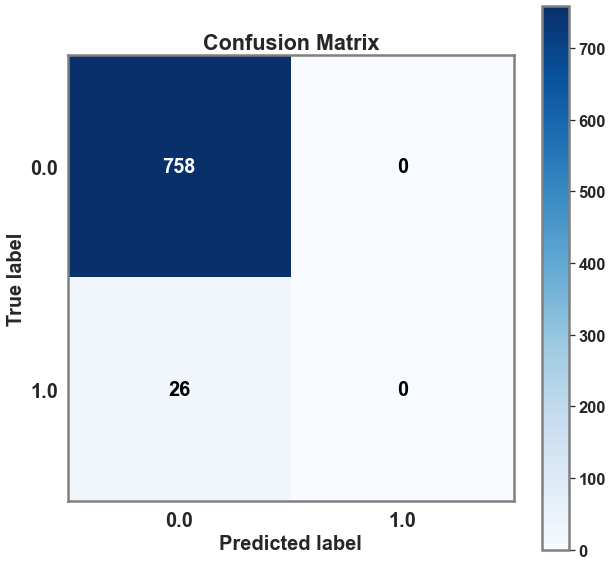

In [24]:
skplt.metrics.plot_confusion_matrix(y_val_combined, y_pred, figsize=(10,10), text_fontsize=20);

In [25]:
print(classification_report(y_val_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       758
         1.0       0.00      0.00      0.00        26

    accuracy                           0.97       784
   macro avg       0.48      0.50      0.49       784
weighted avg       0.93      0.97      0.95       784



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Full Dataset

#### Model Selection

In [26]:
# first model selection on whole dataset using model selector class (found in utilities.py)
sel_c = ModelSelector(preprocessor_combined, instance_name = "Combined Dataframe")

In [27]:
sel_c.select_model(X_finaltest_combined, y_finaltest_combined, True)

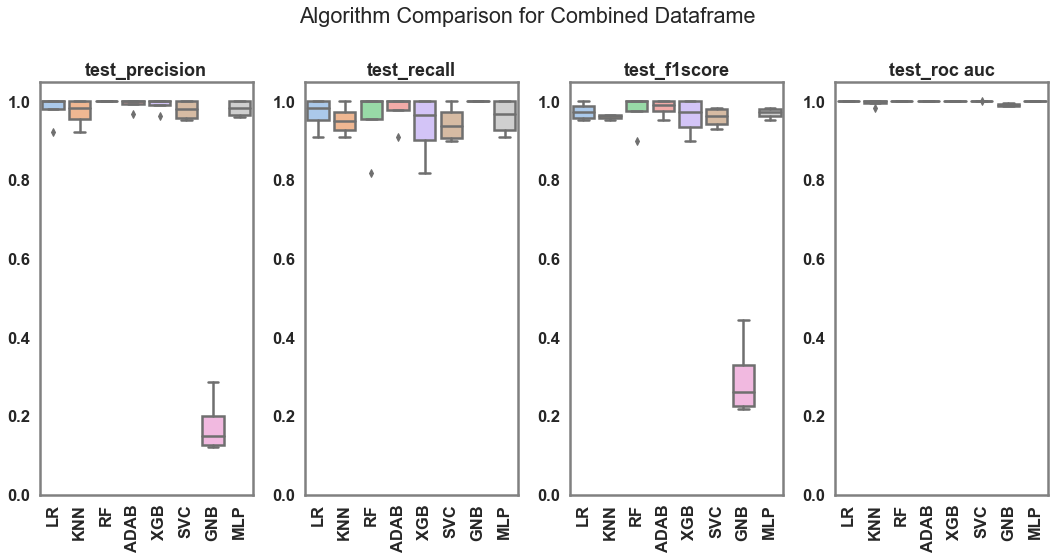

In [28]:
sel_c.plot_selection()

#### xgb gridsearch

In [29]:
#xgb hast good f1 score and is time efficient , so this one is used in grid search, parameter in grid represent best ones found
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.3],
                 'xgbclassifier__n_estimators':[150],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [30]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = make_pipeline(preprocessor_combined,xgb_clf)

In [31]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs = -1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 150}


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784



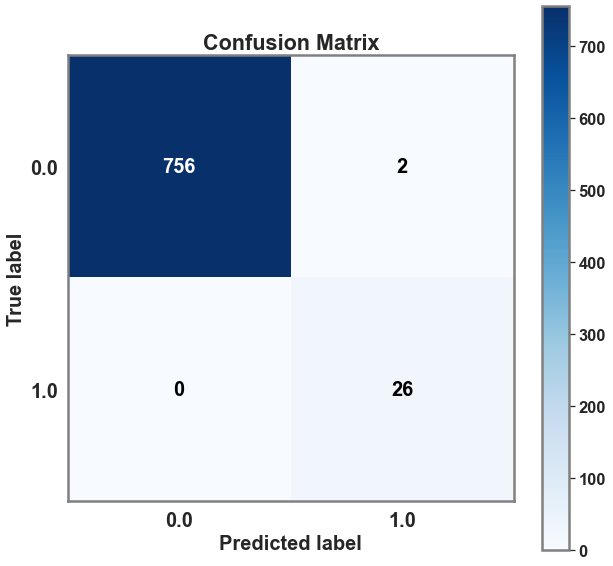

In [37]:
evaluation(grid_xgb, X_val_combined, y_val_combined)

#### feature importances

In [33]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.3,
                        max_depth= 5, n_estimators = 150)

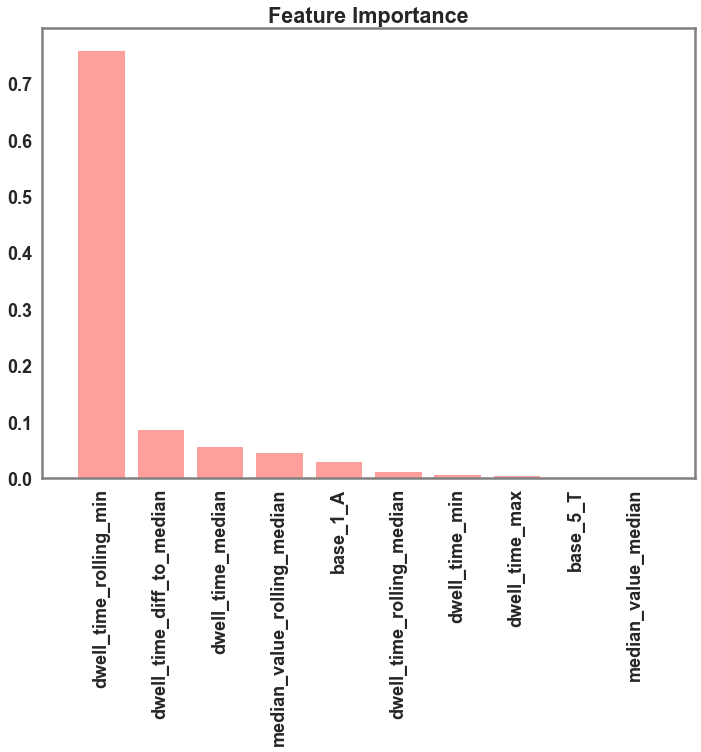

In [34]:
feature_importances(xgb, preprocessor_combined, X_finaltest_combined, y_finaltest_combined)

### Limited Dataset

#### Model Selection

![alt text](figures/cl_model_selection.png)

#### Performance After Gridsearch

![alt text](figures/cl_conf_matrix.png)

#### Feature importances

![alt text](figures/cl_feature_importances.png)